In [1]:
from langgraph.runtime import Runtime
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing import Protocol, TypedDict, Any, List, Optional, Annotated
from langchain_ollama import ChatOllama
from langchain.messages import AIMessage, HumanMessage, SystemMessage
from rich.markdown import Markdown
from rich.console import Console
import asyncio
from variable_importance.utils.output_manager import OutputManager
from variable_importance.utils.code_executer import OutputCapturingExecutor, ExecutionResult
import pandas as pd
import numpy as np
import os
import operator
from pathlib import Path

In [6]:
from typing import TypedDict, Literal, TypeAlias
from dataclasses import Field as DataclassField

JOKE_RATING = Literal['funny', 'not-funny']

class State(TypedDict):
    topic: str
    joke: str
    joke_rating: JOKE_RATING
    joke_critique: str
    final_joke: str

llm = ChatOllama(
    model="gemma3:12b",
    base_url="http://100.91.155.118:11434",
    temperature=0.0
)

In [7]:
def generate_joke(state: State):
    # Implementation to generate and improve jokes based on the state
    class JokeOutput(BaseModel):
        joke: str = Field(..., description="The generated joke")
    joke_llm = llm.with_structured_output(JokeOutput)

    if state.get("joke_critique"):
        joke: JokeOutput = joke_llm.invoke(f"Improve the following joke based on this critique: {state['joke_critique']}. The original joke is: {state['joke']}")
    else:
        joke: JokeOutput = joke_llm.invoke(f"Tell me a joke about {state['topic']}")

    return {"joke": joke.joke}
    
   

def critique_joke(state: State):
    class Critique(BaseModel):
        critique: str = Field(..., description="Critique of the joke and suggestions for improvement")
        rating: Literal['funny', 'not-funny'] = Field(..., description="Rating of the joke as funny or not-funny. If the joke is funny, rate it as 'funny', otherwise rate it as 'not-funny'.")
    critique_llm = llm.with_structured_output(Critique)
    
    joke = state.get("joke", "")
    rating = critique_llm.invoke(
        [
            SystemMessage(content="You are a professional comedy critic. Provide constructive feedback on the joke provided by the user, focusing on humor, originality, and relevance to the topic. Also, rate the joke as either 'funny' or 'not-funny'. If the joke is funny, rate it as 'funny', otherwise rate it as 'not-funny'."),
            HumanMessage(content=f"Here is the joke for the topic {state['topic']}: {joke}"),
        ]
    )
    return {"joke_critique": rating.critique, "joke_rating": rating.rating}
    

def check_completion(state: State):
    
    if state.get("joke_rating", "not-funny") == "funny":
        return "Complete"
    return "In Progress"
    
def polish_joke(state: State):
    class PolishedJoke(BaseModel):
        final_joke: str = Field(..., description="The polished final version of the joke")
    
    polish_llm = llm.with_structured_output(PolishedJoke)
    if state.get("joke"):
        polished = polish_llm.invoke(
            [
                SystemMessage(content="You are a professional comedian. Polish and enhance the following joke to make it more engaging and humorous. Also, address any critiques provided. Only return the final joke without any additional commentary."),
                HumanMessage(content=f"Polish the following joke: {state['joke']} and address the critiques: {state.get('joke_critique', '')}")
            ]
            )
        return {"final_joke": polished.final_joke}
    return {}
    


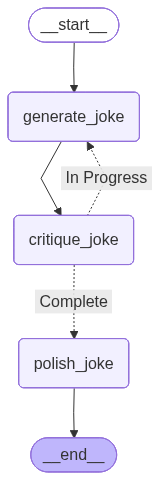

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import display, Image

joke_graph = StateGraph(State)

joke_graph.add_node("generate_joke", generate_joke)
joke_graph.add_node("critique_joke", critique_joke)
joke_graph.add_node("polish_joke", polish_joke)

joke_graph.add_edge(START, "generate_joke")
joke_graph.add_edge("generate_joke", "critique_joke")

joke_graph.add_conditional_edges(
    "critique_joke",
    check_completion,
    {
        "In Progress": "generate_joke",
        "Complete": "polish_joke",
    },
)

joke_graph.add_edge("polish_joke", END)

chain = joke_graph.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

In [13]:
first_node = None
content = ""
for token, metadata in chain.stream({"topic": "Data Science"}, stream_mode='messages'):
    if first_node is None:
        first_node = metadata['langgraph_node']
        print(f"----- Node {first_node} -----")
    this_node = metadata['langgraph_node']
    if this_node != first_node:
        first_node = this_node
        print('\n-----Finished Node-----')
        print(f"----- Node {first_node} -----")
        content = ""
    content += token.content
    if token.content:
        print(token.content, end='', flush=True)

----- Node generate_joke -----
{
  "joke": "Why did the data scientist break up with the statistician?\n\nBecause they said their relationship lacked significance!"
}
-----Finished Node-----
----- Node critique_joke -----
{
  "critique": "Okay, let's break down this Data Science joke. The setup – a breakup scenario – is a solid, relatable starting point. The punchline, 'Because they said their relationship lacked significance!' is *directly* tied to a core statistical concept. That's a big plus – it shows you understand the topic and are trying to incorporate it into the humor. \n\nHowever, the joke lands a little flat. It's a very *literal* interpretation of 'statistical significance.' While clever in its directness, it lacks a layer of unexpectedness or a playful twist. It's almost *too* on-the-nose. A truly great Data Science joke often finds humor in the absurdity of the field, or the quirks of the people in it. This one feels a bit like a textbook example of a pun.\n\nTo improve i

In [2]:
def cp_data_to_folder(input_path: str, output_path: str) -> None:
    import shutil
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    shutil.copy(input_path, output_path)

In [14]:
from langchain.agents import create_agent
from langchain.tools import tool

In [22]:
import hashlib
import re
from pathlib import Path
from typing import List, Dict, Any, Optional
from datetime import datetime
from loguru import logger

try:
    import chromadb
    from chromadb.config import Settings
    CHROMADB_AVAILABLE = True
except ImportError:
    CHROMADB_AVAILABLE = False
    logger.warning("⚠️ ChromaDB not available. Install with: pip install chromadb")


class TextChunker:
    """
    Intelligent text chunking for RAG system.
    
    Splits text into smaller, focused segments while preserving context.
    """
    
    def __init__(self, chunk_size: int = 500, overlap: int = 50):
        """
        Initialize text chunker.
        
        Args:
            chunk_size: Target size for each chunk (in characters)
            overlap: Number of characters to overlap between chunks
        """
        self.chunk_size = chunk_size
        self.overlap = overlap
        logger.info(f"📝 TextChunker initialized (chunk_size={chunk_size}, overlap={overlap})")
    
    def chunk_text(self, text: str, metadata: Optional[Dict[str, Any]] = None) -> List[Dict[str, Any]]:
        """
        Chunk text into smaller, focused segments.
        
        Args:
            text: Text to chunk
            metadata: Base metadata to attach to all chunks
            
        Returns:
            List of chunk dictionaries with text and metadata
        """
        if not text:
            return []
        
        # Small text - no chunking needed
        if len(text) <= self.chunk_size:
            return [{
                "text": text,
                "metadata": {
                    **(metadata or {}),
                    "chunk_index": 0,
                    "total_chunks": 1,
                    "chunk_size": len(text)
                }
            }]
        
        # Split into sentences (preserve sentence boundaries)
        sentences = re.split(r'(?<=[.!?\n])\s+', text)
        
        chunks = []
        current_chunk = []
        current_size = 0
        
        for sentence in sentences:
            sentence_size = len(sentence)
            
            # Start new chunk if adding sentence exceeds size
            if current_size + sentence_size > self.chunk_size and current_chunk:
                chunk_text = " ".join(current_chunk)
                chunks.append(chunk_text)
                
                # Keep overlap from previous chunk
                if self.overlap > 0 and len(chunk_text) > self.overlap:
                    overlap_text = chunk_text[-self.overlap:]
                    # Find sentence boundary in overlap
                    last_period = overlap_text.rfind('. ')
                    if last_period != -1:
                        overlap_text = overlap_text[last_period + 2:]
                    
                    current_chunk = [overlap_text]
                    current_size = len(overlap_text)
                else:
                    current_chunk = []
                    current_size = 0
            
            current_chunk.append(sentence)
            current_size += sentence_size + 1  # +1 for space
        
        # Add final chunk
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        
        # Create chunk dictionaries with metadata
        total_chunks = len(chunks)
        result = []
        
        for idx, chunk_text in enumerate(chunks):
            chunk_metadata = {
                **(metadata or {}),
                "chunk_index": idx,
                "total_chunks": total_chunks,
                "chunk_size": len(chunk_text)
            }
            result.append({
                "text": chunk_text,
                "metadata": chunk_metadata
            })
        
        logger.debug(f"📝 Chunked text into {total_chunks} segments")
        return result


class ContextRAG:
    """
    Enhanced RAG system with chunking for better context retrieval.
    
    Features:
    - Stores chunks instead of full documents
    - Better semantic search granularity
    - Focused context for LLM queries
    """
    
    def __init__(
        self,
        collection_name: str = "workflow_context",
        persist_directory: str = "cache/rag_db",
        chunk_size: int = 500,
        chunk_overlap: int = 50
    ):
        """
        Initialize the RAG system.
        
        Args:
            collection_name: Name of the ChromaDB collection
            persist_directory: Directory to persist the database
            chunk_size: Size of text chunks
            chunk_overlap: Overlap between chunks
        """
        if not CHROMADB_AVAILABLE:
            logger.error("❌ ChromaDB not available. RAG system disabled.")
            self.enabled = False
            return
        
        self.enabled = True
        self.persist_directory = Path(persist_directory).resolve()
        self.persist_directory.mkdir(parents=True, exist_ok=True)
        
        # Initialize chunker
        self.chunker = TextChunker(chunk_size=chunk_size, overlap=chunk_overlap)
        
        # Initialize ChromaDB client
        self.client = chromadb.PersistentClient(
            path=str(self.persist_directory),
            settings=Settings(
                anonymized_telemetry=False,
                allow_reset=True
            )
        )
        
        # Get or create collection
        try:
            self.collection = self.client.get_or_create_collection(
                name=collection_name,
                metadata={"hnsw:space": "cosine"}
            )
            logger.info(f"📚 ContextRAG initialized: {collection_name}")
            logger.info(f"   Stored documents: {self.collection.count()}")
        except Exception as e:
            logger.error(f"❌ Failed to initialize collection: {e}")
            self.enabled = False
    
    def _generate_id(self, content: str, doc_type: str, chunk_idx: int = 0) -> str:
        """Generate a unique ID for a chunk."""
        hash_input = f"{doc_type}:{content[:100]}:{chunk_idx}:{datetime.now().isoformat()}"
        return hashlib.md5(hash_input.encode()).hexdigest()
    
    def _clean_metadata(self, metadata: Dict[str, Any]) -> Dict[str, Any]:
        """
        Clean metadata for ChromaDB compatibility.
        ChromaDB only accepts: str, int, float, bool, or None values.
        """
        cleaned = {}
        for key, value in metadata.items():
            if value is None:
                cleaned[key] = None
            elif isinstance(value, (str, int, float, bool)):
                cleaned[key] = value
            elif isinstance(value, list):
                if len(value) == 0:
                    cleaned[key] = ""
                elif all(isinstance(v, str) for v in value):
                    cleaned[key] = ", ".join(value)
                else:
                    cleaned[key] = str(value)
            elif isinstance(value, dict):
                import json
                cleaned[key] = json.dumps(value)
            else:
                cleaned[key] = str(value)
        
        return cleaned
    
    def add_plot_analysis(
        self,
        plot_name: str,
        plot_path: str,
        analysis: str,
        stage_name: str,
        workflow_id: str,
        metadata: Optional[Dict[str, Any]] = None
    ):
        """
        Add a plot analysis to the RAG system with chunking.
        
        Args:
            plot_name: Name of the plot file
            plot_path: Path to the plot file
            analysis: Analysis text from vision LLM
            stage_name: Workflow stage name
            workflow_id: Workflow ID
            metadata: Additional metadata
        """
        if not self.enabled:
            return
        
        try:
            # Prepare base metadata
            base_metadata = {
                "type": "plot_analysis",
                "plot_name": plot_name,
                "plot_path": plot_path,
                "stage_name": stage_name,
                "workflow_id": workflow_id,
                "timestamp": datetime.now().isoformat()
            }
            
            if metadata:
                base_metadata.update(metadata)
            
            # Chunk the analysis
            doc_text = f"Plot: {plot_name}\n\nAnalysis:\n{analysis}"
            chunks = self.chunker.chunk_text(doc_text, base_metadata)
            
            # Add all chunks to collection
            documents = []
            metadatas = []
            ids = []
            
            for chunk in chunks:
                chunk_text = chunk["text"]
                chunk_metadata = self._clean_metadata(chunk["metadata"])
                chunk_id = self._generate_id(chunk_text, "plot_analysis", chunk["metadata"]["chunk_index"])
                
                documents.append(chunk_text)
                metadatas.append(chunk_metadata)
                ids.append(chunk_id)
            
            self.collection.add(
                documents=documents,
                metadatas=metadatas,
                ids=ids
            )
            
            logger.info(f"📊 Added plot analysis to RAG: {plot_name} ({len(chunks)} chunks)")
            
        except Exception as e:
            logger.error(f"❌ Failed to add plot analysis: {e}")
    
    def add_code_execution(
        self,
        code: str,
        stdout: str,
        stderr: str,
        stage_name: str,
        workflow_id: str,
        success: bool,
        metadata: Optional[Dict[str, Any]] = None
    ):
        """
        Add code execution results to RAG with chunking.
        
        Args:
            code: Executed code
            stdout: Standard output
            stderr: Standard error
            stage_name: Workflow stage name
            workflow_id: Workflow ID
            success: Whether execution was successful
            metadata: Additional metadata
        """
        if not self.enabled:
            return
        
        try:
            # Prepare base metadata
            base_metadata = {
                "type": "code_execution",
                "stage_name": stage_name,
                "workflow_id": workflow_id,
                "success": success,
                "has_error": bool(stderr),
                "timestamp": datetime.now().isoformat(),
                "code_length": len(code),
                "output_length": len(stdout)
            }
            
            if metadata:
                base_metadata.update(metadata)
            
            # Create document text
            doc_text = f"""
Stage: {stage_name}
Status: {'Success' if success else 'Failed'}

Code:
{code}

Output:
{stdout}
"""
            
            if stderr:
                doc_text += f"\nErrors:\n{stderr}"
            
            # Chunk the document
            chunks = self.chunker.chunk_text(doc_text, base_metadata)
            
            # Add all chunks
            documents = []
            metadatas = []
            ids = []
            
            for chunk in chunks:
                chunk_text = chunk["text"]
                chunk_metadata = self._clean_metadata(chunk["metadata"])
                chunk_id = self._generate_id(chunk_text, "code_execution", chunk["metadata"]["chunk_index"])
                
                documents.append(chunk_text)
                metadatas.append(chunk_metadata)
                ids.append(chunk_id)
            
            self.collection.add(
                documents=documents,
                metadatas=metadatas,
                ids=ids
            )
            
            logger.info(f"💻 Added code execution to RAG: {stage_name} ({len(chunks)} chunks)")
            
        except Exception as e:
            logger.error(f"❌ Failed to add code execution: {e}")
    
    def add_summary(
        self,
        summary: str,
        stage_name: str,
        workflow_id: str,
        metadata: Optional[Dict[str, Any]] = None
    ):
        """Add a summary to RAG with chunking."""
        if not self.enabled:
            return
        
        try:
            base_metadata = {
                "type": "summary",
                "stage_name": stage_name,
                "workflow_id": workflow_id,
                "timestamp": datetime.now().isoformat()
            }
            
            if metadata:
                base_metadata.update(metadata)
            
            doc_text = f"Summary for {stage_name}:\n{summary}"
            chunks = self.chunker.chunk_text(doc_text, base_metadata)
            
            documents = []
            metadatas = []
            ids = []
            
            for chunk in chunks:
                chunk_text = chunk["text"]
                chunk_metadata = self._clean_metadata(chunk["metadata"])
                chunk_id = self._generate_id(chunk_text, "summary", chunk["metadata"]["chunk_index"])
                
                documents.append(chunk_text)
                metadatas.append(chunk_metadata)
                ids.append(chunk_id)
            
            self.collection.add(
                documents=documents,
                metadatas=metadatas,
                ids=ids
            )
            
            logger.info(f"📝 Added summary to RAG: {stage_name} ({len(chunks)} chunks)")
            
        except Exception as e:
            logger.error(f"❌ Failed to add summary: {e}")
    
    def query_relevant_context(
        self,
        query: str,
        workflow_id: Optional[str] = None,
        stage_name: Optional[str] = None,
        doc_types: Optional[List[str]] = None,
        n_results: int = 10
    ) -> List[Dict[str, Any]]:
        """
        Query for relevant context chunks.
        
        Args:
            query: User query text
            workflow_id: Filter by workflow ID
            stage_name: Filter by stage name
            doc_types: Filter by document types
            n_results: Number of results to retrieve
            
        Returns:
            List of relevant context chunks with metadata
        """
        if not self.enabled:
            return []
        
        try:
            # Build where filter
            where_filter = None
            
            if workflow_id and doc_types:
                where_filter = {
                    "$and": [
                        {"workflow_id": workflow_id},
                        {"type": {"$in": doc_types}}
                    ]
                }
            elif workflow_id and stage_name:
                where_filter = {
                    "$and": [
                        {"workflow_id": workflow_id},
                        {"stage_name": stage_name}
                    ]
                }
            elif workflow_id:
                where_filter = {"workflow_id": workflow_id}
            elif stage_name:
                where_filter = {"stage_name": stage_name}
            elif doc_types:
                where_filter = {"type": {"$in": doc_types}}
            
            # Query the collection
            results = self.collection.query(
                query_texts=[query],
                n_results=n_results,
                where=where_filter
            )
            
            if not results['documents'] or not results['documents'][0]:
                logger.info(f"🔍 No relevant context found for query")
                return []
            
            # Format results
            contexts = []
            for i, doc in enumerate(results['documents'][0]):
                context = {
                    "document": doc,
                    "metadata": results['metadatas'][0][i],
                    "distance": results['distances'][0][i] if 'distances' in results else None
                }
                contexts.append(context)
            
            logger.info(f"🔍 Retrieved {len(contexts)} relevant context chunks")
            return contexts
            
        except Exception as e:
            logger.error(f"❌ Failed to query context: {e}")
            return []
    
    def get_context_summary(
        self,
        query: str,
        workflow_id: Optional[str] = None,
        stage_name: Optional[str] = None,
        max_tokens: int = 2000
    ) -> str:
        """
        Get a concise context summary relevant to the query.
        
        Combines relevant chunks into a focused context string.
        """
        if not self.enabled:
            return ""
        
        contexts = self.query_relevant_context(
            query=query,
            workflow_id=workflow_id,
            stage_name=stage_name,
            n_results=15  # Get more chunks since they're smaller
        )
        
        if not contexts:
            return ""
        
        # Build context string
        context_parts = []
        total_length = 0
        max_chars = max_tokens * 4  # Rough approximation
        
        # Group chunks by document
        doc_groups = {}
        for ctx in contexts:
            doc_type = ctx['metadata'].get('type', 'unknown')
            stage = ctx['metadata'].get('stage_name', 'unknown')
            chunk_idx = ctx['metadata'].get('chunk_index', 0)
            
            key = f"{doc_type}:{stage}"
            if key not in doc_groups:
                doc_groups[key] = []
            doc_groups[key].append((chunk_idx, ctx))
        
        # Add grouped chunks to context
        for key, chunks in doc_groups.items():
            # Sort chunks by index
            chunks.sort(key=lambda x: x[0])
            
            doc_type, stage = key.split(':', 1)
            context_parts.append(f"\n[{doc_type.upper()} - {stage}]")
            
            for _, ctx in chunks:
                doc_text = ctx['document']
                logger.debug(f"Adding chunk (type={doc_type}, stage={stage}, size={len(doc_text)}) to context")
                if total_length + len(doc_text) > max_chars:
                    remaining = max_chars - total_length
                    if remaining > 100:
                        doc_text = doc_text[:remaining] + "..."
                    else:
                        break
                
                context_parts.append(doc_text)
                total_length += len(doc_text)
                
                if total_length >= max_chars:
                    break
            
            if total_length >= max_chars:
                break
        logger.debug(f"Total context length: {total_length} characters")
        return "\n".join(context_parts)
    

    def delete_by_workflow(self, workflow_id: str):
        """Delete all documents for a specific workflow."""
        if not self.enabled:
            return
        
        try:
            results = self.collection.get(
                where={"workflow_id": workflow_id}
            )
            
            if results['ids']:
                self.collection.delete(ids=results['ids'])
                logger.info(f"🗑️ Deleted {len(results['ids'])} chunks for workflow: {workflow_id}")
        
        except Exception as e:
            logger.error(f"❌ Failed to delete workflow documents: {e}")
    
    def get_stats(self) -> Dict[str, Any]:
        """Get RAG system statistics."""
        if not self.enabled:
            return {"enabled": False}
        
        try:
            total_count = self.collection.count()
            
            # Get type breakdown
            results = self.collection.get()
            type_counts = {}
            if results['metadatas']:
                for metadata in results['metadatas']:
                    doc_type = metadata.get('type', 'unknown')
                    type_counts[doc_type] = type_counts.get(doc_type, 0) + 1
            
            return {
                "enabled": True,
                "total_chunks": total_count,
                "type_breakdown": type_counts,
                "persist_directory": str(self.persist_directory),
                "collection_name": self.collection.name,
                "chunk_size": self.chunker.chunk_size,
                "chunk_overlap": self.chunker.overlap
            }
        
        except Exception as e:
            logger.error(f"❌ Failed to get stats: {e}")
            return {"enabled": True, "error": str(e)}
    
    def clear_all(self):
        """Clear all documents from the RAG system."""
        if not self.enabled:
            return
        
        try:
            self.client.delete_collection(self.collection.name)
            self.collection = self.client.create_collection(
                name=self.collection.name,
                metadata={"hnsw:space": "cosine"}
            )
            logger.info("🗑️ Cleared all RAG chunks")
        
        except Exception as e:
            logger.error(f"❌ Failed to clear RAG: {e}")



In [23]:
context_rag = ContextRAG()

2025-11-22 12:05:16.284 | INFO     | __main__:__init__:34 - 📝 TextChunker initialized (chunk_size=500, overlap=50)
2025-11-22 12:05:16.342 | INFO     | __main__:__init__:171 - 📚 ContextRAG initialized: workflow_context
2025-11-22 12:05:16.342 | INFO     | __main__:__init__:172 -    Stored documents: 0


In [25]:
context_rag.get_context_summary(
    query="What are the key factors influencing variable importance in machine learning models?",
    workflow_id=None,
    stage_name=None,
    max_tokens=2000
)

2025-11-22 12:06:35.596 | INFO     | __main__:query_relevant_context:464 - 🔍 No relevant context found for query


''

In [ ]:
@tool
def get_current_time() -> str:
    """Get the current time as a string."""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# @tool
# def search_current_knoweledge(query: str) -> str:
#     """Query a RAG system for relevant context based on the query

#     If no relevant context is found, return an empty string.
#     """
#     # Placeholder implementation
#     return context_rag.get_context_summary(
#         query=query,
#         workflow_id="agent",
#         stage_name="agent",
#         max_tokens=1000
#     )

class Context(BaseModel):
    content: str = Field(..., description="The relevant context content")
    timestamp: Optional[str] = Field(None, description="The timestamp of the context")
    relevance_score: Optional[float] = Field(None, description="The relevance score of the context chunk")

@tool
def search_current_knoweledge(query: str) -> list[Context]:
    """Query a RAG system for relevant context based on the query

    If no relevant context is found, returns an empty list.
    """
    # Placeholder implementation
    context = context_rag.query_relevant_context(
        query=query,
        workflow_id="agent",
        stage_name="agent",
        n_results=5
    )
    return [
        Context(
            content=ctx['document'],
            timestamp=ctx['metadata'].get('timestamp'),
            relevance_score=1.0-ctx.get('distance', 1.0)
        )
        for ctx in context
    ]

@tool
def store_knowledge(document: str, current_time: str) -> str:
    """Store useful information the user provide in the RAG system for future reference
    along with the current time.
    """
    context_rag.add_summary(
        summary=f"{document}",
        stage_name="agent",
        workflow_id="agent",
        metadata={"time": current_time}
    )
    return "Document stored successfully."

llm = ChatOllama(
    model="qwen3:8b",
    base_url="http://100.91.155.118:11434",
    temperature=0.0
)

agent = create_agent(
    llm,
    tools=[get_current_time, store_knowledge, search_current_knoweledge],
    system_prompt="You are a helpful assistant that can provide and store information for the user",
)

In [33]:
context_rag.get_context_summary(
        query="Lunch",
        workflow_id="agent",
        stage_name="agent",
        max_tokens=1000
    )

2025-11-23 01:05:38.387 | INFO     | __main__:query_relevant_context:477 - 🔍 Retrieved 1 relevant context chunks
2025-11-23 01:05:38.387 | DEBUG    | __main__:get_context_summary:536 - Adding chunk (type=summary, stage=agent, size=62) to context
2025-11-23 01:05:38.387 | DEBUG    | __main__:get_context_summary:552 - Total context length: 62 characters


'\n[SUMMARY - agent]\nSummary for agent:\nUser has a lunch scheduled tomorrow at 3pm.'

In [34]:
context_rag.query_relevant_context(
        query="Lunch",
        workflow_id="agent",
        stage_name="agent",
        n_results=5
)

2025-11-23 01:06:01.929 | INFO     | __main__:query_relevant_context:477 - 🔍 Retrieved 1 relevant context chunks


[{'document': 'Summary for agent:\nUser has a lunch scheduled tomorrow at 3pm.',
  'metadata': {'total_chunks': 1,
   'stage_name': 'agent',
   'chunk_size': 62,
   'chunk_index': 0,
   'timestamp': '2025-11-22T12:10:38.820197',
   'workflow_id': 'agent',
   'type': 'summary'},
  'distance': 0.4513198137283325}]

In [28]:
first_node = None
content = ""
for token, metadata in agent.stream({"messages": [HumanMessage(content="I have a lunch tomorrow at 3pm do not forget!")]}, stream_mode='messages'):
    if first_node is None:
        first_node = metadata['langgraph_node']
        print(f"----- Node {first_node} -----")
    this_node = metadata['langgraph_node']
    if this_node != first_node:
        first_node = this_node
        print('\n-----Finished Node-----')
        print(f"----- Node {first_node} -----")
        content = ""
    content += token.content
    if token.content:
        print(token.content, end='', flush=True)

----- Node model -----


2025-11-22 12:10:38.967 | INFO     | __main__:add_summary:402 - 📝 Added summary to RAG: agent (1 chunks)



-----Finished Node-----
----- Node tools -----
Document stored successfully.
-----Finished Node-----
----- Node model -----
I've noted your lunch appointment for tomorrow at 3pm. Let me know if you need help with anything else! 😊

In [32]:
first_node = None
content = ""
for token, metadata in agent.stream({"messages": [HumanMessage(content="How long between now and my lunch?")]}, stream_mode='messages'):
    if first_node is None:
        first_node = metadata['langgraph_node']
        print(f"----- Node {first_node} -----")
    this_node = metadata['langgraph_node']
    if this_node != first_node:
        first_node = this_node
        print('\n-----Finished Node-----')
        print(f"----- Node {first_node} -----")
        content = ""
    content += token.content
    if token.content:
        print(token.content, end='', flush=True)

print("\nDone!")

----- Node model -----


2025-11-22 12:13:38.131 | INFO     | __main__:query_relevant_context:477 - 🔍 Retrieved 1 relevant context chunks
2025-11-22 12:13:38.131 | DEBUG    | __main__:get_context_summary:536 - Adding chunk (type=summary, stage=agent, size=62) to context
2025-11-22 12:13:38.131 | DEBUG    | __main__:get_context_summary:552 - Total context length: 62 characters



-----Finished Node-----
----- Node tools -----

[SUMMARY - agent]
Summary for agent:
User has a lunch scheduled tomorrow at 3pm.
-----Finished Node-----
----- Node model -----

-----Finished Node-----
----- Node tools -----
2025-11-22 12:13:39
-----Finished Node-----
----- Node model -----
The time between now (12:13 PM on November 22, 2025) and your lunch (3:00 PM on November 23, 2025) is **26 hours and 47 minutes**.
Done!


In [3]:
class Code(BaseModel):
    code: str = Field(..., description="Python code to be executed")
    task: str = Field(..., description="Description of the task to be performed")

class State(TypedDict):
    code: str
    user_query: str
    input_data_path: str
    stage_name: str
    code_output: ExecutionResult
    summary: str
    graph_summaries: Annotated[List[str], operator.add]

class GraphState(TypedDict):
    graph_summary: str
    graph_summaries: Annotated[List[str], operator.add]

class ExecutionDeps(TypedDict):
    executor: OutputCapturingExecutor
    output_manager: OutputManager

executor = OutputCapturingExecutor()
output_mgr = OutputManager(workflow_id="test_workflow_001")

2025-11-22 11:38:36.446 | INFO     | variable_importance.utils.code_executer:__init__:58 - OutputCapturingExecutor initialized (timeout=300s)
2025-11-22 11:38:36.448 | INFO     | variable_importance.utils.output_manager:__init__:95 - 📁 OutputManager initialized: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001


In [4]:
def write_code_for_task(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_llm = ChatOllama(
        model="qwen3-coder:30b",
        temperature=0,
        base_url="http://100.91.155.118:11434")

    structured_code_llm = code_llm.with_structured_output(Code)

    input_data_path = Path(state["input_data_path"])
    user_query = state["user_query"]

    code = structured_code_llm.invoke([
        SystemMessage(
            content=f"You are a helpful data science agent that writes Python code to perform data analysis tasks. Write Python code to load data from `{input_data_path.name}` and solve the users query. Any plots should be saved to files in the current working directory. Use pandas for data manipulation and any necessary libraries for analysis."),
        HumanMessage(content=user_query),
    ])
    
    return {'code': code.code}


In [5]:
def move_data_to_execution_folder(state: State, runtime: Runtime[ExecutionDeps]) -> None:
    stage_name = state["stage_name"]
    path = runtime.context["output_manager"].get_stage_dir(stage_name)
    execution_path = path / "execution"/ Path(state['input_data_path']).name
    cp_data_to_folder(state["input_data_path"], execution_path)
    return {}

def interpret_graph(state: GraphState, runtime: Runtime[ExecutionDeps]) -> str:
    llm = ChatOllama(
        model="gemma3:27b",
        temperature=0,
        base_url="http://100.91.155.118:11434/"
    )
    summary = llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that summarizes the results of code execution. Provide a detailed summary of the code execution results and the statistical findings. Justify your summary with the output and errors from the code execution."),
        HumanMessage(
            content=f"The graph summary is: {state['graph_summary']}")
    ])
    return {'graph_summary': summary.content}

async def execute_code(state: State, runtime: Runtime[ExecutionDeps]) -> Any:
    executor = runtime.context["executor"]
    output_manager = runtime.context["output_manager"]
    stage_name = state["stage_name"]
    code = state["code"]

    result = await executor.execute_with_output_manager(
        code=code,
        stage_name=stage_name,
        output_manager=output_manager,
        code_filename="code_with_data.py"
    )

    return {'code_output': result}

def code_fix(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_llm = ChatOllama(
        model="qwen3-coder:30b",
        temperature=0,
        base_url="http://100.91.155.118:11434")
    structured_code_llm = code_llm.with_structured_output(Code)
    code = state["code"]
    error = state["code_output"].error
    output = state['code_output'].stdout
    fixed_code = structured_code_llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that writes Python code. The following code has an error. Please fix the code to resolve the error."),
        AIMessage(content=code),
        HumanMessage(content=f"The error message is: {error}, and current output is {output}"),
    ])
    return {'code': fixed_code.code}

def check_execution_success(state: State, runtime: Runtime[ExecutionDeps]) -> bool:
    if state["code_output"].success:
        return "SUCCESS"
    else:
        return "FAILURE"

def summarize_results(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_output = state["code_output"]
    
    llm = ChatOllama(
        model="gemma3:27b",
        temperature=0,
        base_url="http://100.91.155.118:11434/"
    )
    summary = llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that summarizes the results of code execution. Provide a detailed summary of the code execution results and the statistical findings. Justify your summary with the output and errors from the code execution."),
        HumanMessage(
            content=f"The code was executed with the following output:\n\n{code_output.stdout}\n\nAnd the following error (if any):\n\n{code_output.error}")
    ])
    return {'summary': summary.content}

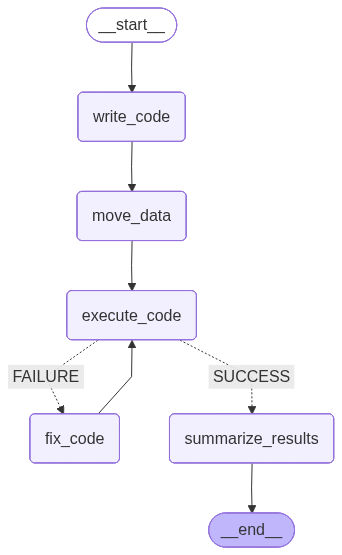

In [6]:
code_graph = StateGraph(State, ExecutionDeps)

code_graph.add_node("write_code", write_code_for_task)
code_graph.add_node("move_data", move_data_to_execution_folder)
code_graph.add_node("execute_code", execute_code)
code_graph.add_node("fix_code", code_fix)
code_graph.add_node("summarize_results", summarize_results)

code_graph.add_edge(START, "write_code")


code_graph.add_edge("write_code", "move_data")
code_graph.add_edge("move_data", "execute_code")
code_graph.add_conditional_edges(
    "execute_code",
    check_execution_success,
    {"SUCCESS": "summarize_results", "FAILURE": "fix_code"}
)
code_graph.add_edge("fix_code", "execute_code")

code_graph.add_edge("summarize_results", END)


code_workflow = code_graph.compile()

display(Image(code_workflow.get_graph(xray=True).draw_mermaid_png()))

In [8]:
result = await code_workflow.ainvoke(
    {
        "user_query": "Perform a summary analysis of the dataset.",
        "input_data_path": "data.csv",
        "stage_name": "eda"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-18 23:59:53.558 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-18 23:59:53.559 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: eda
2025-11-18 23:59:53.559 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-18 23:59:53.563 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/eda/execution
2025-11-18 23:59:55.017 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (1.45s)
2025-11-18 23:59:55.018 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-18 23:59:55.018 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:289 - 📦 Saving 

In [9]:
console = Console()
console.print(Markdown(result["summary"]))

Summary of Dataset Analysis                                            

The code successfully loaded and analyzed a dataset containing 1500 samples and 6 features (feature_0 to feature_4)
along with a target variable. Here's a detailed breakdown of the findings:                                         

1. Data Loading and Shape:                                                                                         

 • The dataset was loaded without errors.                                                                          
 • The dataset's shape is (1500, 6), indicating 1500 rows (samples) and 6 columns (features + target).             

2. Data Inspection (First 5 Rows):                                                                                 

 • The first 5 rows were displayed, providing a glimpse of the data distribution. The features and target variable 
   appear to be continuous numerical values.                                                                       

3. Data Information:                                                                                               

 • The dataset is a Pandas DataFrame.                                                                              
 • All 6 columns are of type float64.                                                                              
 • The DataFrame uses a RangeIndex from 0 to 1499.                                                                 

4. Descriptive Statistics:                                                                                         

 • Mean: The mean values for each feature and the target variable are relatively close to zero, suggesting a       
   centered distribution.                                                                                          
 • Standard Deviation: The standard deviations range from approximately 1.22 to 2.45 for the features and 1.30 for 
   the target, indicating the spread or dispersion of the data.  Feature_1 has the highest standard deviation,     
   implying greater variability.                                                                                   
 • Min/Max: The minimum and maximum values provide the range of each feature and the target. The ranges vary       
   considerably between features.                                                                                  
 • Quantiles (25%, 50%, 75%): These values show the distribution of the data. The median (50th percentile) is a    
   good indicator of the central tendency, and the interquartile range (IQR = 75% - 25%) provides information about
   the spread of the middle 50% of the data.                                                                       

5. Missing Values:                                                                                                 

 • There are no missing values in any of the columns, indicating a complete dataset.                               

6. Duplicate Rows:                                                                                                 

 • The analysis confirms that there are no duplicate rows in the dataset.                                          

7. Data Types:                                                                                                     

 • All columns are correctly identified as float64.                                                                

8. Additional Outputs:                                                                                             

 • The code generated a visualization (saved as 'dataset_analysis_visualizations.png') and a summary report (saved 
   as 'dataset_summary.txt').  While the contents of these files aren't provided, they likely contain visual       
   representations of the data distribution (histograms, box plots, scatter plots) and a more detailed textual     
   summary of the analysis.                                                        

In [ ]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"Perform a linear regression on the dataset provided and identify important features for predicting the target, try using statsmodels. Here is a summary of the data {result['summary']}",
        "input_data_path": "data.csv",
        "stage_name": "regression"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-19 00:00:45.717 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-19 00:00:45.718 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: regression
2025-11-19 00:00:45.718 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-19 00:00:45.724 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/regression/execution
2025-11-19 00:00:47.091 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (1.37s)
2025-11-19 00:00:47.092 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-19 00:00:47.092 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:2

In [11]:
console.print(Markdown(result["summary"]))

Summary of Code Execution and Statistical Findings                                 

The code executed successfully, performing data loading, cleaning, exploratory data analysis (EDA), and linear     
regression modeling. Here's a detailed summary of the results:                                                     

1. Data Loading and Cleaning:                                                                                      

 • A dataset with 1500 samples and 6 features (feature_0 to feature_4) along with a target variable was loaded     
   successfully.                                                                                                   
 • The dataset was checked for missing values and duplicates.  No missing values or duplicate rows were found,     
   indicating a clean dataset ready for analysis.                                                                  

2. Exploratory Data Analysis (EDA):                                                                                

 • Descriptive statistics (mean, standard deviation, min, max, quartiles) were calculated for each feature and the 
   target variable. This provides a basic understanding of the data distribution.                                  
 • The mean of the target variable is approximately 0.0046, suggesting the target is centered around zero.         
 • Feature_0 has the largest standard deviation (1.217), indicating the greatest variability.                      
 • The range of values for each feature is substantial, suggesting a wide spread of data.                          

3. Linear Regression Modeling:                                                                                     

 • A linear regression model was trained to predict the target variable using all 6 features.                      
 • Model Performance: The R-squared value is 0.422, meaning that approximately 42.2% of the variance in the target 
   variable is explained by the model. The adjusted R-squared is 0.420, which accounts for the number of predictors
   in the model.                                                                                                   
 • Statistical Significance: The F-statistic is 217.7 with a very small p-value (1.14e-174), indicating that the   
   model as a whole is statistically significant.                                                                  
 • Coefficient Analysis: The coefficients from the linear regression model represent the change in the target      
   variable for a one-unit change in the corresponding feature, holding all other features constant.               
    • feature_0 has a positive and statistically significant coefficient (0.4845, p < 0.001). This suggests that an
      increase in feature_0 is associated with an increase in the target variable.                                 
    • feature_1 has a negative and statistically significant coefficient (-0.2151, p < 0.001). This suggests that  
      an increase in feature_1 is associated with a decrease in the target variable.                               
    • feature_2, feature_3, and feature_4 are not statistically significant (p > 0.05), indicating that they do not
      have a significant impact on the target variable in this model.                                              
    • The intercept (const) is not statistically significant (p = 0.763).                                          

4. Feature Importance:                                                                                             

 • Based on the p-values from the linear regression model, feature_0 and feature_1 are identified as the most      
   important features, as they are the only ones with statistically significant coefficients.                      
 • The absolute values of the coefficients can also be used as a measure of feature importance.  Feature_0 has the 
   largest absolute coefficient (0.4845), indicating it has the strongest influ

In [12]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"What would the expected change in the target be if the value of feature 5 changed from 1 to 2 given the previous linear model results. Here is a summary of previous analysis{result['summary']}. {result['code_output'].stdout}",
        "input_data_path": "data.csv",
        "stage_name": "what_if_analysis"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-19 00:01:55.059 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-19 00:01:55.060 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: what_if_analysis
2025-11-19 00:01:55.061 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-19 00:01:55.066 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/what_if_analysis/execution
2025-11-19 00:01:55.597 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (0.53s)
2025-11-19 00:01:55.598 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-19 00:01:55.598 | INFO     | variable_importance.utils.code_executer:execute_with_outp

In [15]:
console.print(Markdown(result['summary']))

Summary of Code Execution Results                                         

The code execution successfully calculated the expected change in the target variable when a specific feature      
(feature_0) increases from 1 to 2. The result indicates that increasing feature_0 from 1 to 2 is predicted to      
increase the target variable by 0.4845 units.                                                                      

Justification:                                                                                                     

The output explicitly states: "Expected change in target when feature_0 changes from 1 to 2: 0.4845. This means the
target variable would increase by 0.4845 units."  This is a clear and direct result of the code's operation.       

Statistical Findings:                                                                                              

While the output provides a point estimate of the change, it doesn't provide any information about the statistical 
significance or confidence interval around this estimate.  To fully interpret this result, we would ideally need   
additional information such as:                                                                                    

 • Standard Error:  This would tell us the precision of the estimate.                                              
 • P-value: This would indicate the probability of observing such a change if there was actually no effect.        
 • Confidence Interval: This would provide a range within which we can be reasonably confident the true change     
   lies.                                                                                                           

Without these, we can only state that the model predicts an increase of 0.4845, but we cannot assess the           
reliability of this prediction.                                                                                    

Absence of Errors:                                                                                                 

The fact that there were no errors during execution is positive. It indicates the code ran as expected and produced
a valid result, even if further statistical analysis is needed to fully understand its implications.

In [20]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"Can you perform a sensitivity analysis on the previous linear model results considering the impact of removing features 2 through 4? the data only contains features 0-4. Here is a summary of previous analysis{result['summary']}. {result['code_output'].stdout}",
        "input_data_path": "data.csv",
        "stage_name": "sensitivity_analysis"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-16 20:47:28.611 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-16 20:47:28.612 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: sensitivity_analysis
2025-11-16 20:47:28.612 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-16 20:47:28.614 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/sensitivity_analysis/execution
2025-11-16 20:47:29.509 | ERROR    | variable_importance.utils.code_executer:execute_code:162 - ❌ Execution failed: Exit code: 1
2025-11-16 20:47:29.510 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:289 - 📦 Saving outputs...
2025-11-16 20:47:29.511 | INFO     | variable_importance.utils.output_

In [21]:
console.print(Markdown(result['summary']))

Summary of Code Execution Results: Feature Importance and Model Sensitivity Analysis                

The code execution performed a sensitivity analysis on the coefficient of feature_0 in a model. The goal was to    
quantify how a small change in the coefficient impacts the predicted change in the target variable when feature_0  
changes.                                                                                                           

Key Findings:                                                                                                      

 • Coefficient Change: The original coefficient for feature_0 was 0.4845. After a reduction (presumably through    
   some model modification or regularization, though the specifics aren't provided), the coefficient became 0.4819.
   This represents a decrease of 0.0026.                                                                           
 • Sensitivity: The sensitivity analysis shows that a change of 0.0026 in the coefficient of feature_0 results in a
   corresponding change of -0.0026 in the expected change in the target variable when feature_0 increases from 1 to
   2.  This is a direct, linear relationship as expected given the simple model structure implied by focusing on a 
   single coefficient.                                                                                             
 • Expected Change in Target: The original model predicted a decrease of 0.4845 in the target variable when        
   feature_0 changed from 1 to 2. The reduced model predicted a decrease of 0.4819. The difference between these   
   predictions (-0.0026) confirms the sensitivity calculation.                                                     

Justification:                                                                                                     

The output clearly shows the original and reduced coefficients for feature_0. The "Sensitivity" value (0.0026) is  
calculated as the difference between the original and reduced coefficients.  The "Expected change in target" values
are calculated by multiplying the original/reduced coefficients by the change in feature_0 (2-1 = 1).  The "Change 
in expected change" is simply the difference between the expected changes calculated using the original and reduced
models, and it matches the sensitivity value.                                                                      

In conclusion, the code successfully quantified the impact of a small change in the coefficient of feature_0 on the
model's predictions. The sensitivity analysis demonstrates a linear relationship, where a decrease of 0.0026 in the
coefficient leads to a decrease of 0.0026 in the predicted change in the target variable.  The absence of errors   
indicates the code executed without issues.

In [13]:
result = await executor.execute_with_output_manager(
        code="import pand",
        stage_name="test",
        output_manager=OutputManager(workflow_id="test_workflow_001"),
        code_filename="code_with_data.py"
    )

2025-11-19 00:03:19.168 | INFO     | variable_importance.utils.output_manager:__init__:95 - 📁 OutputManager initialized: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001
2025-11-19 00:03:19.168 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-19 00:03:19.169 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: test
2025-11-19 00:03:19.170 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-19 00:03:19.173 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/test/execution
2025-11-19 00:03:19.493 | ERROR    | variable_importance.utils.code_executer:execute_code:162 - ❌ Execution failed: Exit code: 1
2025-11-19 00:03:19.494 | 

In [16]:
result.stderr

'Traceback (most recent call last):\n  File \x1b"/Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/test/execution/_agent_code.py"\x1b, line \x1b11\x1b, in \x1b<module>\x1b\n    import pand\n\x1bModuleNotFoundError\x1b: \x1bNo module named \'pand\'\x1b\n'